In [1]:
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import pandas as pd
from scipy import stats
import statsmodels.formula.api as sm
import pandas as pd

In [2]:
def plot_empirical_with_best_fit(domain, statistic):
    nodes_col = []
    stats_col = []
    name_col = []
    
    for domain_temp in ["Social", "Biological", "Informational", "Technological"]:
        all_files = os.listdir("../Results/empirical_netstats/" + domain_temp)
        for gml_graphname in all_files:
            if statistic in ['k', 'cc', 'r']:
                pickle_in = open("../Results/empirical_netstats/" + domain_temp + "/" + gml_graphname[:-4] + ".pkl", "rb")
                Results = pickle.load(pickle_in)
                pickle_in.close()

                if statistic == "k":
                    k = 2 * Results[2] / Results[1] # 2m/n
                    stats_col.append(k)
                elif statistic == "cc":
                    cc = Results[3]
                    stats_col.append(cc)
                else:
                    r = Results[4] 
                    stats_col.append(r)
            elif statistic == 'mgd':
                pickle_in = open("../Results/real_MGD/" + domain_temp + "/" + gml_graphname[:-4] + ".pkl", "rb")
                Results = pickle.load(pickle_in)
                pickle_in.close()
                mgd = Results[3]
                stats_col.append(mgd)

            name_col.append(Results[0])
            nodes_col.append(Results[1])
        
    X_others = [] # lighter shade circles
    Y_others = []
    X_domain = [] # colored triangles
    Y_domain = []

    color_map = {"Social" : "orange", "Biological" : "green", "Informational": "blue", "Technological": "purple"}
    for i in range(len(stats_col)):
        gml_filename = name_col[i]
        filename = gml_filename[:-4]
        if "_" + domain + "_" in filename:
            X_domain.append(nodes_col[i])
            Y_domain.append(stats_col[i])
        else:
            X_others.append(nodes_col[i])
            Y_others.append(stats_col[i])

    plt.figure(figsize = (5, 5))

    Y_no0s = []
    X_no0s = []
    for i in range(len(Y_domain)):
        if Y_domain[i] != 0:
            Y_no0s.append(Y_domain[i])
            X_no0s.append(X_domain[i])

    plt.scatter(X_others, Y_others, c = "grey", alpha = 0.4)
    plt.scatter(X_no0s, Y_no0s, c = color_map[domain], alpha = 0.8, marker = "v", s = 150) # 0.8 for orange

    if statistic in ["k", "cc"]:
        data_df = pd.DataFrame({'x': np.log10(X_no0s), 'y': np.log10(Y_no0s)})
        ols_model = sm.ols(formula = 'y ~ x', data=data_df)
        results = ols_model.fit()

        intercept = results.params[0]
        slope = results.params[1]

        print("10**intercept = ", 10**intercept, " slope = ", slope)

        plt.xscale('log')
        plt.yscale('log')

    elif statistic in ["mgd", "r"]:
        data_df = pd.DataFrame({'x': np.log10(X_no0s), 'y': Y_no0s})
        ols_model = sm.ols(formula = 'y ~ x', data=data_df)
        results = ols_model.fit()

        intercept = results.params[0]
        slope = results.params[1]

        print("intercept = ", intercept, " slope = ", slope)

        plt.xscale('log')

    if domain == "Social":
        if statistic == "k":
            plt.ylim(0.7, 400)
            plt.ylabel("Mean degree, <k>", fontsize = 20, color = "black")
        elif statistic == "mgd":
            plt.ylabel("Mean geodesic distance, L", fontsize = 20, color = "black")
        elif statistic == "cc":
            plt.ylim(0.0001, 1.4)
            plt.ylabel("Clustering coefficient, C", fontsize = 20, color = "black")
        elif statistic == "r":
            plt.ylim(-0.9, 0.79)
            plt.ylabel("Degree assortativity, r", fontsize = 20, color = "black")

    plt.xlim(1, 10000000)
    plt.xlabel("Nodes, n", fontsize = 20, color = "black")
    if statistic == "r":
        plt.xticks(fontsize = 20, color = "black")
    else:
        plt.xticks(fontsize = 0, color = "black")

    if domain == "Social":
        plt.yticks(fontsize = 20, color = "black")
    else:
        plt.yticks(fontsize = 0, color = "black")        


    X_no0s_for_plotting = [i for i in range(5, 7000000, 10000)]
    boot_slopes = []
    boot_interc = []
    n_boots = 2000
    n_samples = len(X_no0s)

    for _ in range(n_boots):
        bootstrap_df = data_df.sample(n=n_samples, replace=True)
        ols_model_boot = sm.ols(formula = 'y ~ x', data=bootstrap_df)
        results_boot = ols_model_boot.fit()
        intercept_boot = results_boot.params[0]
        slope_boot = results_boot.params[1]

        if statistic in ["k", "cc"]:
            plt.plot(sorted(X_no0s_for_plotting), 10**(intercept_boot + (slope_boot*np.log10(sorted(X_no0s_for_plotting)))), c = 'pink', lw = 1, alpha = 0.04)
            boot_slopes.append(slope_boot)
            boot_interc.append(10**intercept_boot)

        elif statistic in ["mgd", "r"]:
            plt.plot(sorted(X_no0s_for_plotting), intercept_boot + (slope_boot*np.log10(sorted(X_no0s_for_plotting))), c = 'pink', lw = 1, alpha = 0.04)
            boot_slopes.append(slope_boot)
            boot_interc.append(intercept_boot)
    
    print("intercept SD = ", np.std(boot_interc), " slope SD = ", np.std(boot_slopes))

    # Plot the original observed best fit line (as a thick red line)
    if statistic in ["k", "cc"]:
        plt.plot(sorted(X_no0s_for_plotting), 10**(intercept + (slope*np.log10(sorted(X_no0s_for_plotting)))), 'r-', lw = 5)
    elif statistic in ["mgd", "r"]:
        plt.plot(sorted(X_no0s_for_plotting), intercept + (slope*np.log10(sorted(X_no0s_for_plotting))), 'r-', lw = 5)

    plt.show()

Domain = Social Statistic = k
10**intercept =  4.231546464007738  slope =  0.12569376542077376
intercept SD =  0.8370664458680876  slope SD =  0.035919388097389635


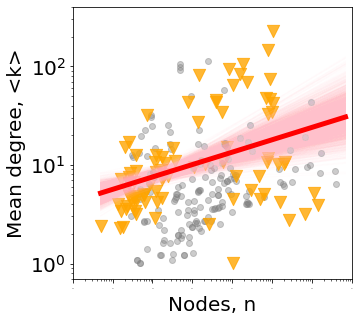

Domain = Social Statistic = mgd
intercept =  1.3822386162319429  slope =  0.5965458782517524
intercept SD =  0.18783071119714514  slope SD =  0.08286488150590489


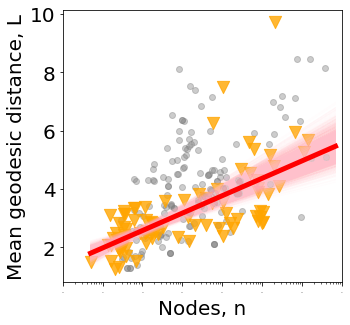

Domain = Social Statistic = cc
10**intercept =  1.0676120095301413  slope =  -0.298486149164452
intercept SD =  0.20264689868900615  slope SD =  0.034370573741977876


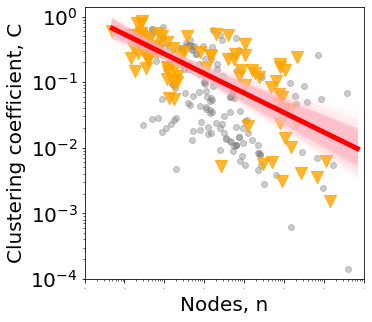

Domain = Social Statistic = r
intercept =  -0.13127955324653345  slope =  0.020575714793504625
intercept SD =  0.05477772159352576  slope SD =  0.014002997422963412


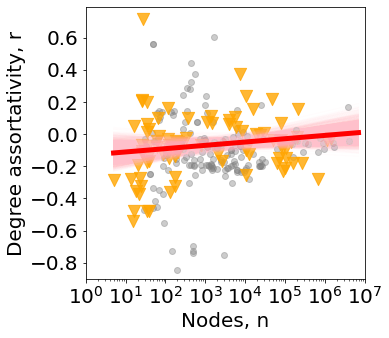

Domain = Biological Statistic = k
10**intercept =  4.058953970668307  slope =  0.03671140302525509
intercept SD =  2.2570702784415584  slope SD =  0.06936948031073198


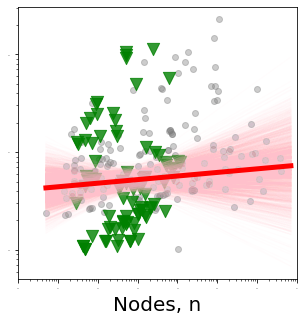

Domain = Biological Statistic = mgd
intercept =  -0.17636417248027245  slope =  1.417227440524028
intercept SD =  0.4541372430120531  slope SD =  0.1861123693301973


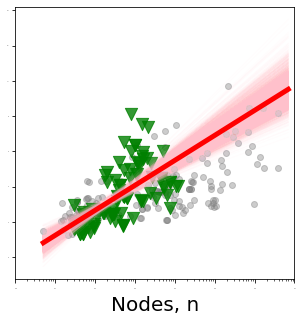

Domain = Biological Statistic = cc
10**intercept =  0.7330928143115522  slope =  -0.30806206681379866
intercept SD =  0.5226142903904348  slope SD =  0.08937500760520428


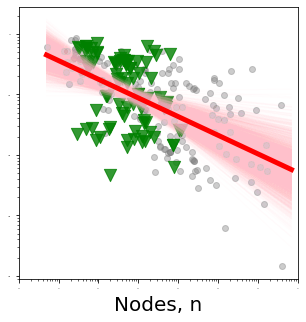

Domain = Biological Statistic = r
intercept =  -0.14352857013869308  slope =  0.02094575191790324
intercept SD =  0.11287313663653585  slope SD =  0.0364408911590242


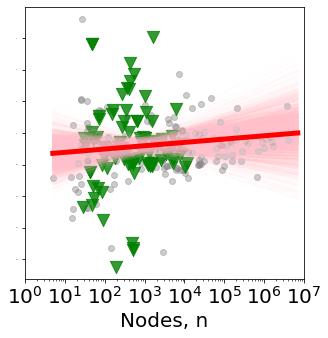

Domain = Informational Statistic = k
10**intercept =  3.471633168754355  slope =  0.08955276295976763
intercept SD =  1.2452182049461455  slope SD =  0.03192498462935937


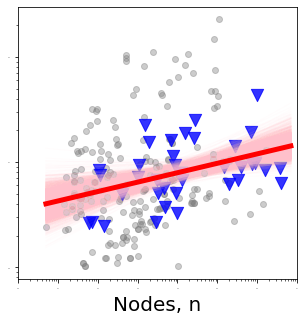

Domain = Informational Statistic = mgd
intercept =  0.5009156847409871  slope =  0.9642985971908563
intercept SD =  0.6772883198999485  slope SD =  0.1759929878779037


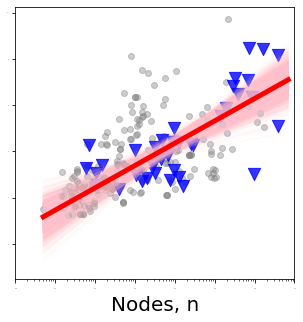

Domain = Informational Statistic = cc
10**intercept =  0.5351109165632004  slope =  -0.2578589524246221
intercept SD =  0.6575475377138512  slope SD =  0.0941373297083754


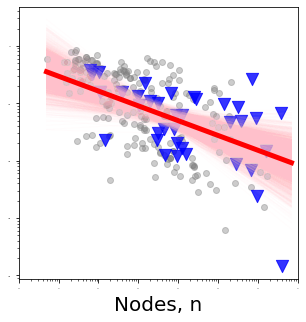

Domain = Informational Statistic = r
intercept =  -0.2797246747884499  slope =  0.037643819344810966
intercept SD =  0.13241506835267403  slope SD =  0.02604758740807803


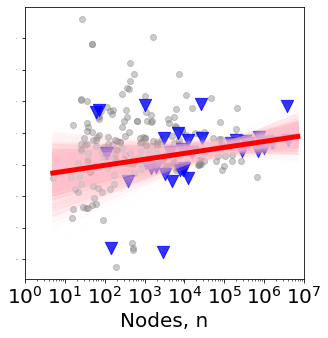

Domain = Technological Statistic = k
10**intercept =  2.824310880583371  slope =  0.08475185942805333
intercept SD =  1.0193926670311175  slope SD =  0.03250921279875427


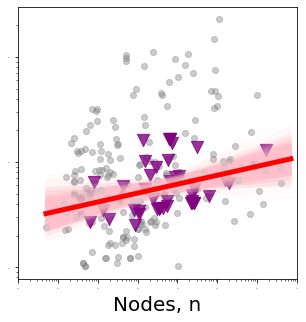

Domain = Technological Statistic = mgd
intercept =  3.608300967615498  slope =  0.18423727960843378
intercept SD =  0.6809533623418411  slope SD =  0.18290579880970761


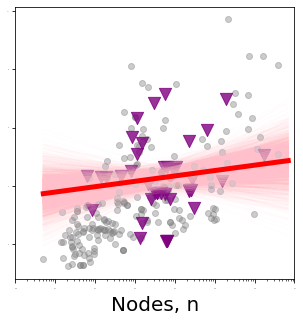

Domain = Technological Statistic = cc
10**intercept =  1.9901541319207865  slope =  -0.5272492590544626
intercept SD =  3.4136212843953597  slope SD =  0.10407058246694689


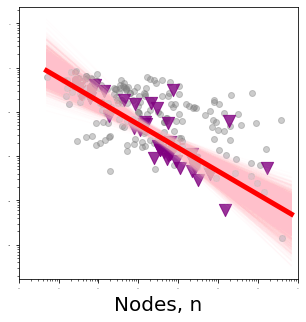

Domain = Technological Statistic = r
intercept =  -0.14309769069420725  slope =  0.0020709781379175257
intercept SD =  0.11832783527197778  slope SD =  0.02953857598225648


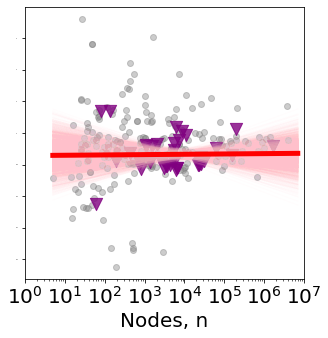

In [3]:
for domain in ["Social", "Biological", "Informational", "Technological"]:
    for statistic in ["k", "mgd", "cc", "r"]:
        print("Domain =", domain, "Statistic =", statistic)
        plot_empirical_with_best_fit(domain = domain, statistic = statistic)